<a href="https://colab.research.google.com/github/Rodman7041/Visionarios_player-ball_recognition/blob/main/Proyecto_Visionarios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visionarios Project

In this project we will implement deep learning to obtain positional data of the ball and players in a soccer match. To begin with, we obtained a dataset with the top view of the field where we first changed the format of the coco.json type to yolov5.txt in order to apply the object recognition procedures that were deepened in the course. 

At the moment of downloading the dataset "Soccer player and ball localization", initially it was planned to implement convolutional neural networks, but it turns out that the dataset contained labels to apply object recognition. This being the case, the strategy was rethought to apply an object recognition algorithm to the dataset. 

First a conversion from coco.json to yolov5.txt was performed but this did not work well since the original dataset contained 2 groups of information being the top view images and the masks representing the information. These 2 sets of images were intermingled with each other and the labels did not correspond to what they should be. Because of this we proceeded to perform a manual relabeling leaving aside the masks in the dataset. 

The number of images to work with was initially 626 images. Because they are a low number for training, some preprocessing was done to increase this number. Among these preprocessing we have: 
- X-axis inversion
- Y-axis inversion
- Image rotation (between -2 and 2°deg)
- Brightness variation (between -30 and 30%)
- Saturation variation (between -20 and 20%) 

The data augmentation was performed by Roboflow and was able to generate a total of 1564 images where: 

- 90% was destined for training
- 6 % was destined to validation
- 4 % was destined for testing

<img src="https://makeml.app/docs/assets/dribble_app_object_detection_tutorial_editorial.png" width="500" align="center" />

## 1. Download the model 

We used git clone to download a github repository that will allow us to work with object recognition using yolov5. It is necessary to take into account that you have to install the minimum requirements to be able to operate with yolov5.

In [1]:
# Clone the model 
!git clone https://github.com/ultralytics/yolov5  

# install dependencies
!pip install -U -r yolov5/requirements.txt  

Cloning into 'yolov5'...
remote: Enumerating objects: 10191, done.
remote: Total 10191 (delta 0), reused 0 (delta 0), pack-reused 10191
Receiving objects: 100% (10191/10191), 10.46 MiB | 24.29 MiB/s, done.
Resolving deltas: 100% (7059/7059), done.
     |████████████████████████████████| 11.2 MB 5.2 MB/s 
     |████████████████████████████████| 15.7 MB 38.5 MB/s 
     |████████████████████████████████| 60.3 MB 1.3 MB/s 
     |████████████████████████████████| 3.1 MB 22.8 MB/s 
     |████████████████████████████████| 596 kB 41.9 MB/s 
     |████████████████████████████████| 62 kB 847 kB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 11.3 MB 16.0 MB/s 
     |████████████████████████████████| 884 kB 36.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: Pillow
    Found existing installation: Pil

We will use Yolov5s because we have two classes and the dataset will be small. As you can see, Yolov5x has more precision and its heavier, which might involve difficulties when deploying. 

In [ ]:
# access the yolov5 folder and show the model's architecture
%cd /content/yolov5
%cat /content/yolov5/models/yolov5s.yaml

/content/yolov5
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4],

In [ ]:
import torch
from IPython.display import Image  # for displaying images
from google.colab import files 

# check if we're using torch with GPU
print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Using torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


## 2. Prepare the dataset


In [ ]:
# You need to sign up in roboflow to get the key and then you can use the dataset. 
# This is the link of our dataset created in roboflow as we mentioned at the beginning
!curl -L "https://app.roboflow.com/ds/2Tuy6KFLz2?key=D5sICdhNFH" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   889  100   889    0     0   1590      0 --:--:-- --:--:-- --:--:--  1587
100 39.5M  100 39.5M    0     0  23.8M      0  0:00:01  0:00:01 --:--:-- 62.5M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/frame_0016_jpg.rf.13b3b11acac504fc08e0be6ebe34e436.jpg  
 extracting: test/images/frame_0050_jpg.rf.da770aa28d97530a36eafbb8b112aef4.jpg  
 extracting: test/images/frame_0059_jpg.rf.69ac68a4e1e851a16e51746967d4824e.jpg  
 extracting: test/images/frame_0063_jpg.rf.386d570eb701ec21fd4f47315ed9235e.jpg  
 extracting: test/images/frame_0069_jpg.rf.3afc7eb7854f97191727b0c8b8da3ac5.jpg  
 extracting: test/images/frame_0071_jpg.rf.337b59a6ba7d3082c4ad789c87b45b1a.jpg  
 extractin

The following is an example of one of the images tagged by us. The yellow bounding boxes represent the "player" tag and the purple ones the "ball" tag

<img src="https://i.ibb.co/gdsR7k4/Whats-App-Image-2021-12-12-at-12-17-16-PM.jpg" width="600" align="center" />

In [ ]:
# visualise the content of data.yaml
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 2
names: ['ball', 'player']

In [ ]:
# define the number of classes
num_classes = 2

from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
# change the location of the training and validation subsets. The rest
# of the file remains equal. 

%%writetemplate /content/yolov5/data.yaml

train: ./train/images
val: ./test/images

nc: 2
names: ['ball', 'player']

In [ ]:
%cat data.yaml


train: ./train/images
val: ./test/images

nc: 2
names: ['ball', 'player']

In [ ]:
# change the number of classes defined in the yolo v5 architectures. the rest remains the same. 
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes 
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%cat models/custom_yolov5s.yaml


# parameters
nc: 2  # number of classes 
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[

## 3. Train the model

Training with Yolov5 can be done by using a script named `train.py`, which will require the following parameters:

* **img:** input image size (width == height)
* **batch:** batch size
* **epochs:** number of training epochs. 
* **data:** path to our yaml file
* **cfg:** model configuration
* **weights:** custom path to save the best weights. 
* **name:** output file with metric results
* **nosave:** boolean that specifies to only save the final checkpoint
* **cache:** boolean that specifies to cache images for faster training

In [ ]:
# Since we exported the dataset for Yolo v5, we don't need to resize the images.
# We will train the model for 80 epoch with batch size of 40
%cd /content/yolov5/
!python train.py --img 416 --batch 40 --epochs 80 --data './data.yaml' --cfg './models/custom_yolov5s.yaml' --weights ''

/content/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=./data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=80, batch_size=40, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-139-g8f35436 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0

## 4. Evaluate the model


After training the model, in the directory /content/yolov5/runs/train/exp/confusion_matrix.png we get the next image that shows the confusion matrix with the information of how good the classes were classified. The main parameter that we look for are the one in the main diagonal that let us know the percentage of truth possitives. Here we can see that the performance of the  classification done on the player label is really good, but for the ball is quite bad.

<img src="https://i.ibb.co/YN3NYwQ/confusion-matrix.png" width="900" align="center" />

Now, we can use the `detect.py` script to run the model inference with the best weights.
- **source:** input images directory or single image path or video path
- **weights:** trained model path
- **conf:** confidence threshold

The following command will process the test images and store them in our inference directory with the predicted bounding boxes.

In [ ]:
# final weights will be stored by default at /content/yolov5/runs/train/exp2/weights/best.pt
%cd /content/yolov5/

!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 416 --conf 0.5 --source ./test/images

/content/yolov5
detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=./test/images, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=1, hide_labels=False, hide_conf=False, half=False, dnn=False
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.0-139-g8f35436 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 232 layers, 7249215 parameters, 0 gradien

Finally, we will use `glob` to find all the path names matching the specified pattern. Then, we will use the display module of IPython to display images easily.

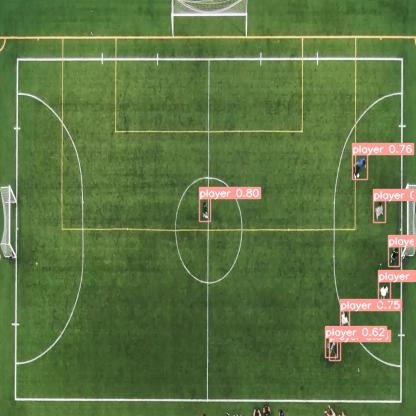

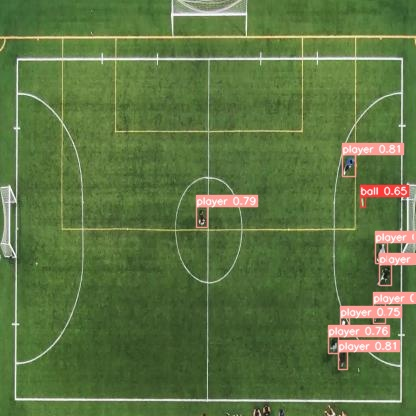

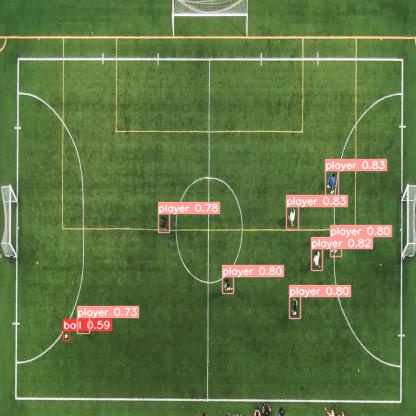

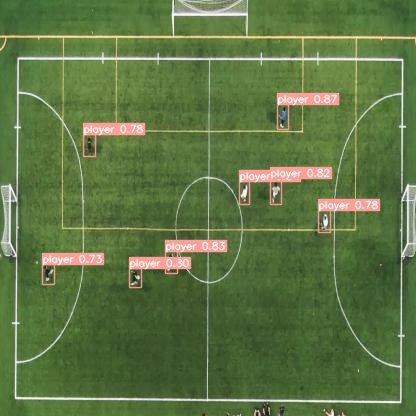

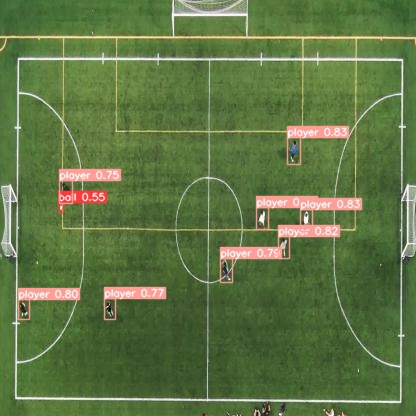

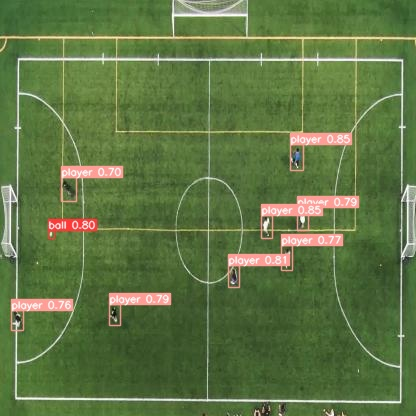

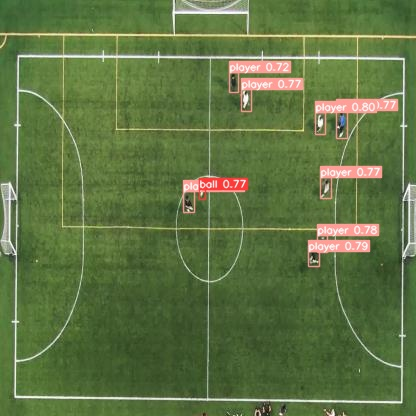

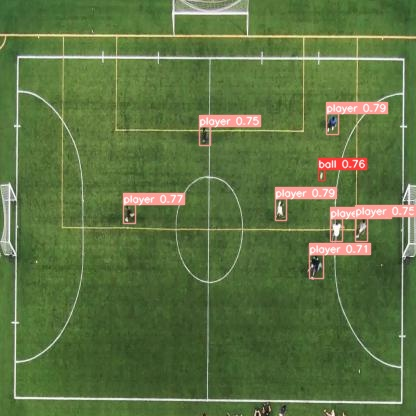

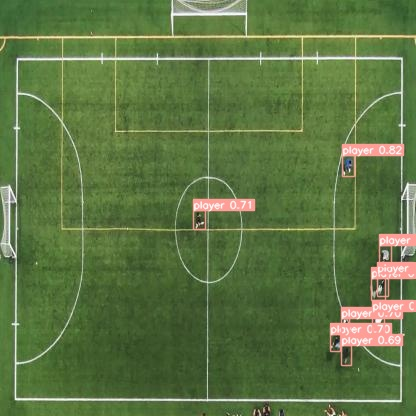

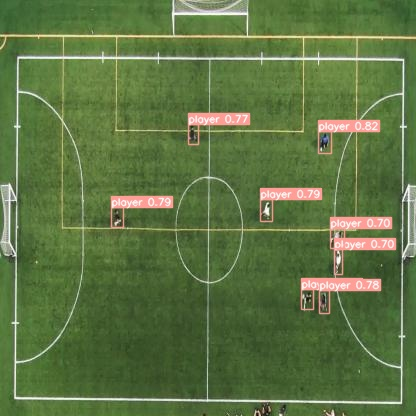

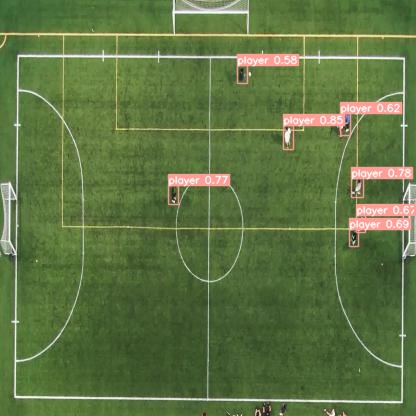

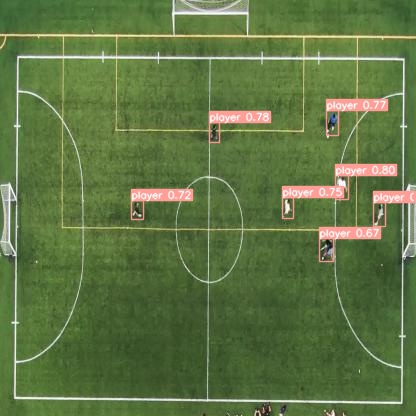

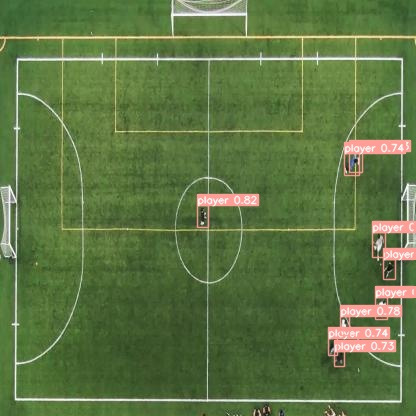

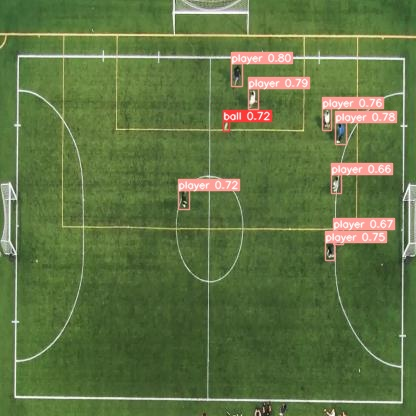

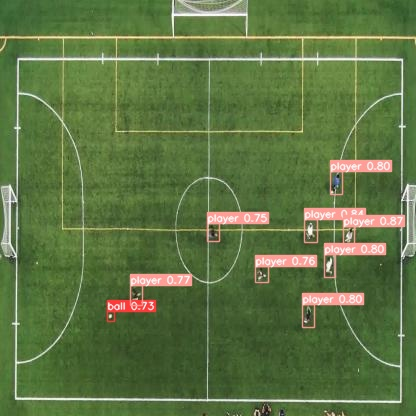

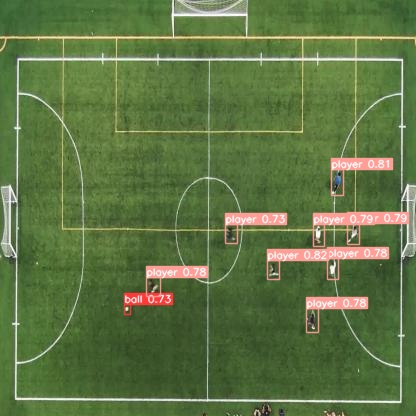

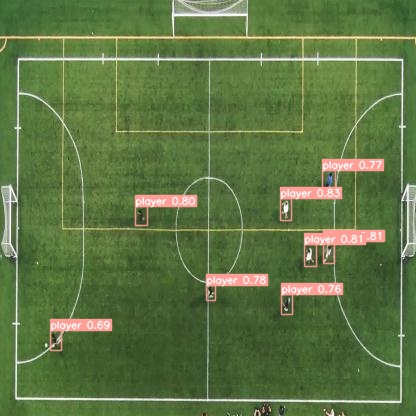

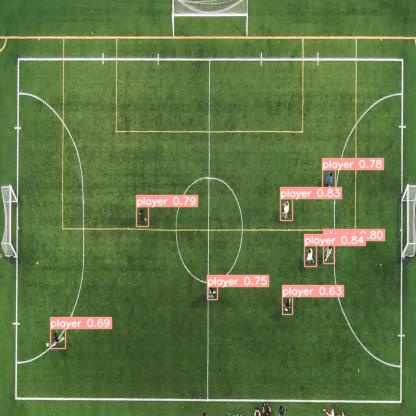

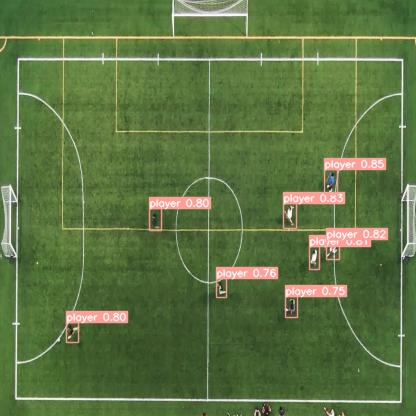

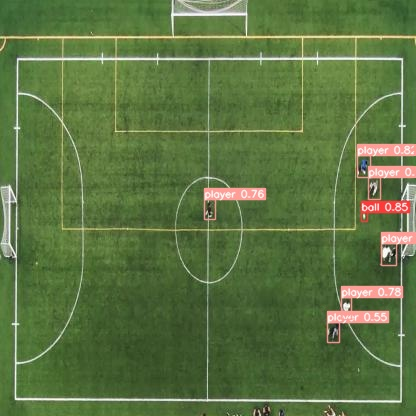

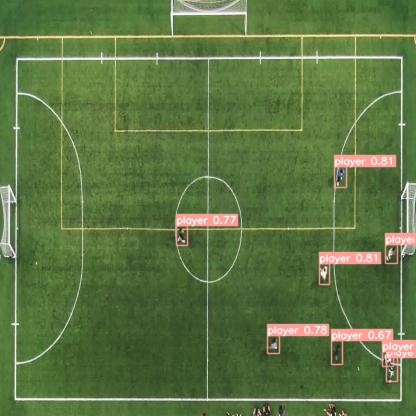

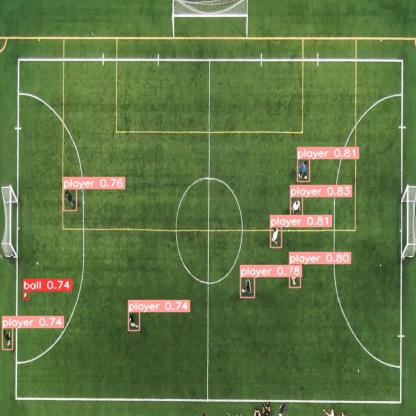

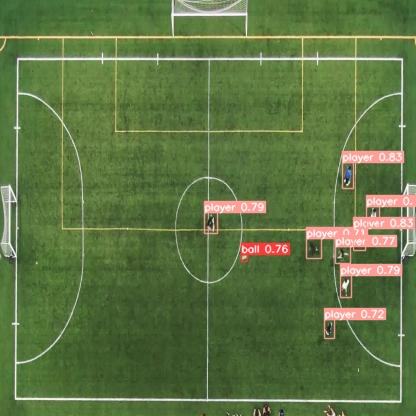

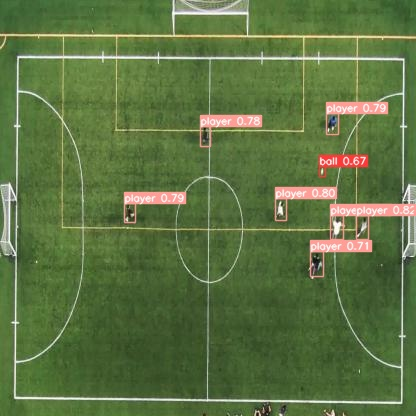

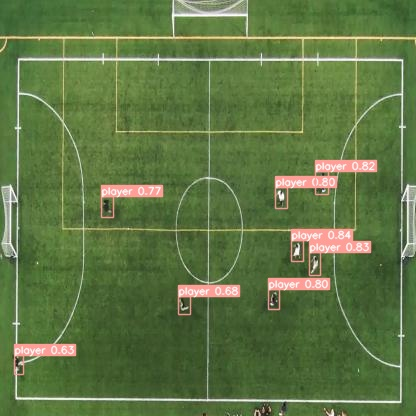

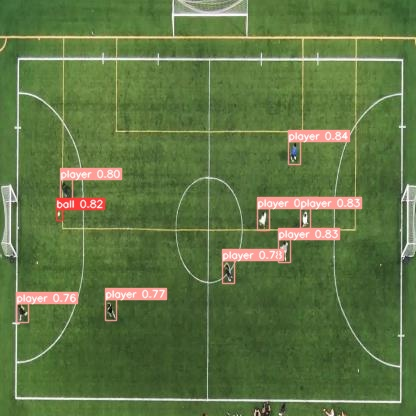

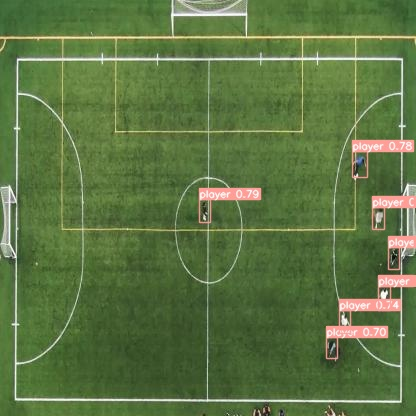

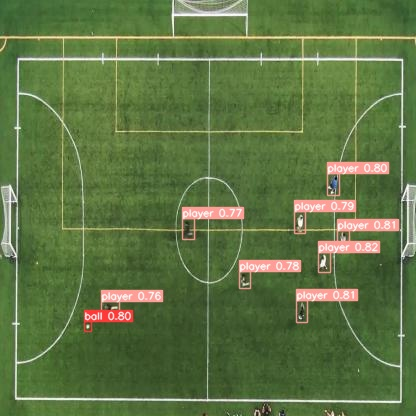

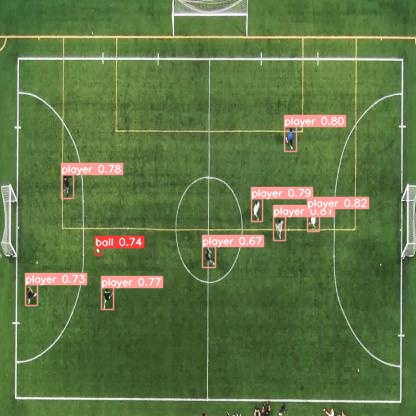

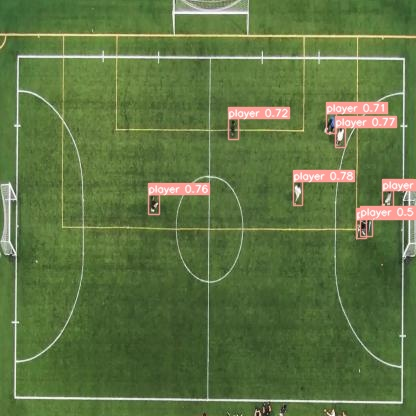

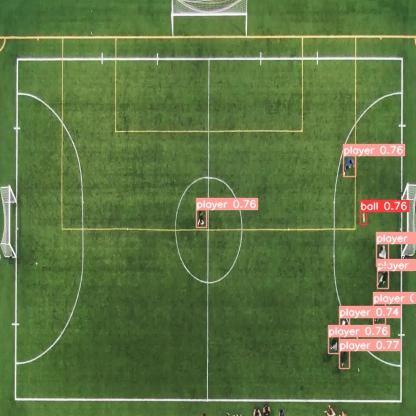

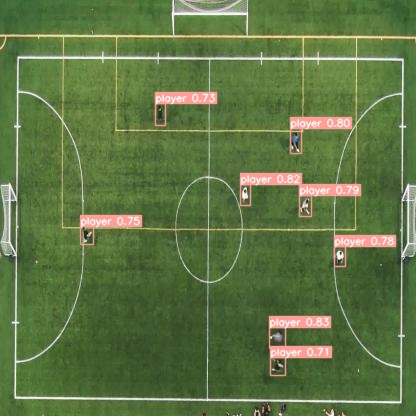

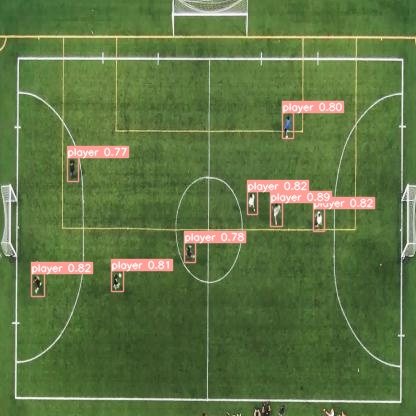

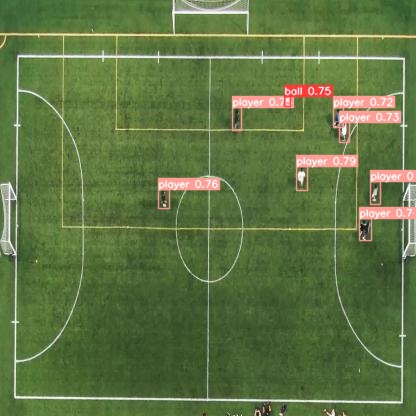

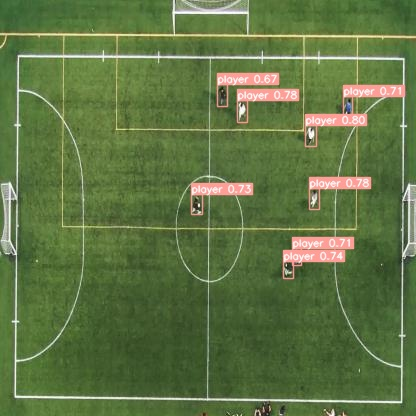

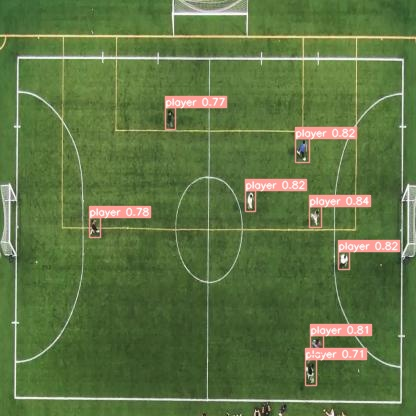

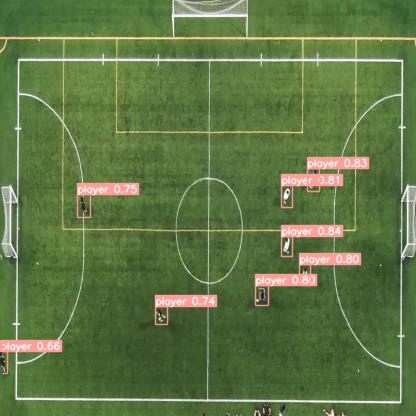

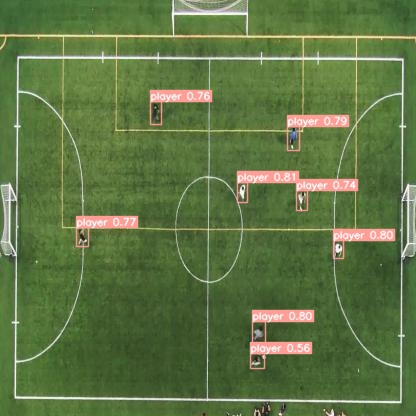

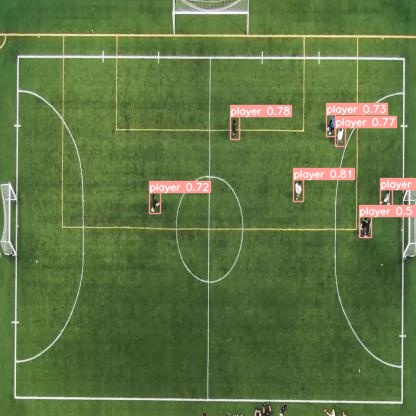

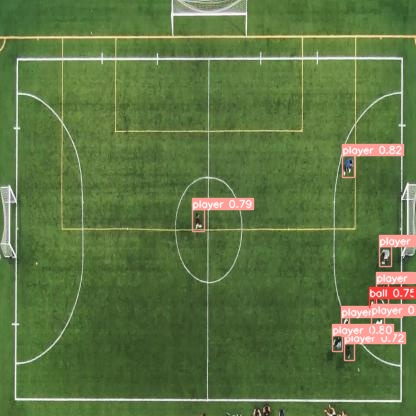

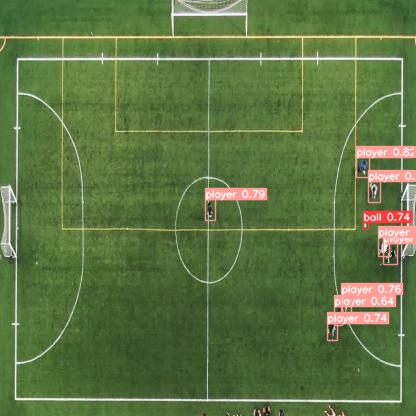

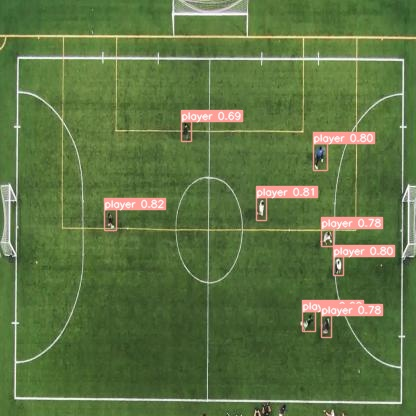

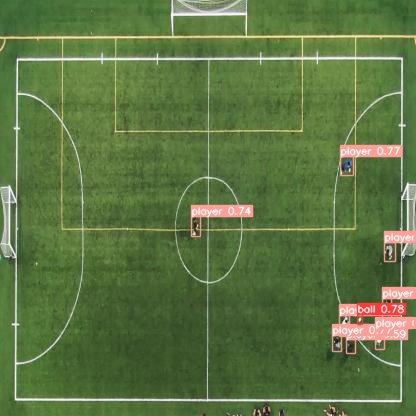

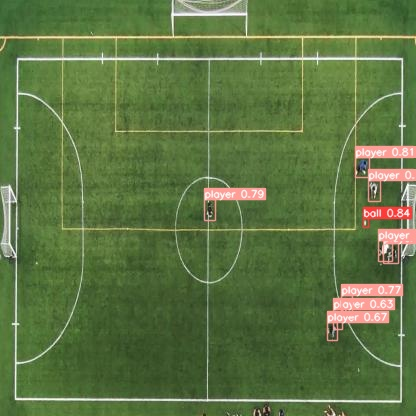

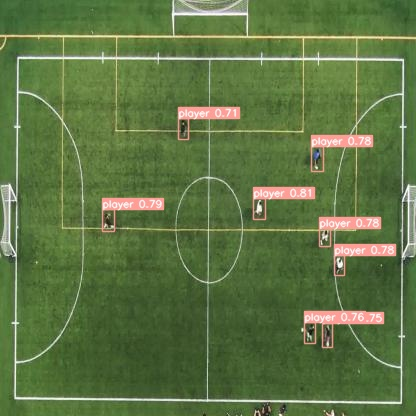

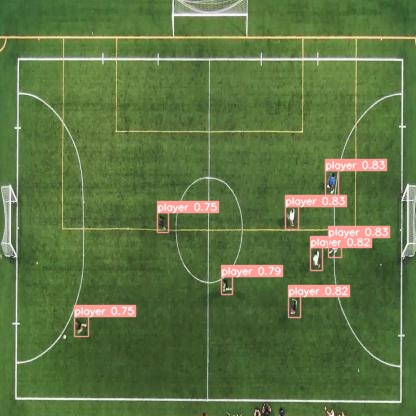

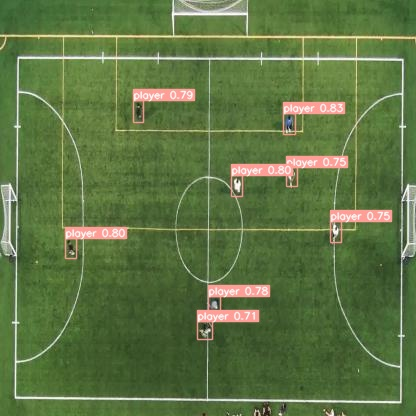

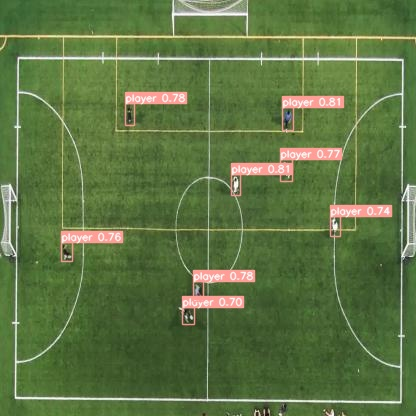

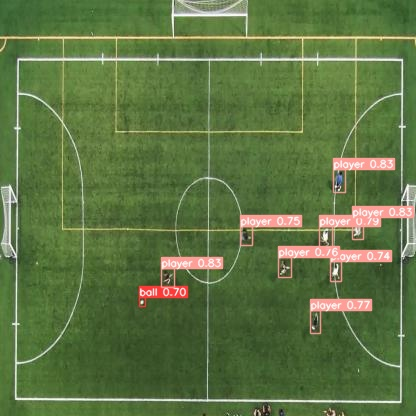

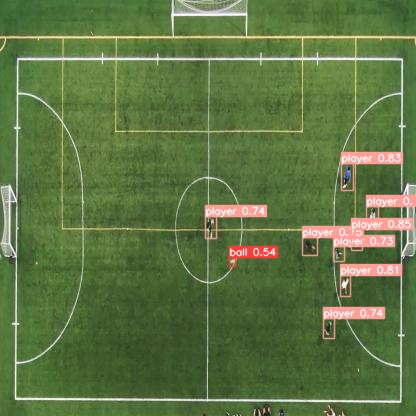

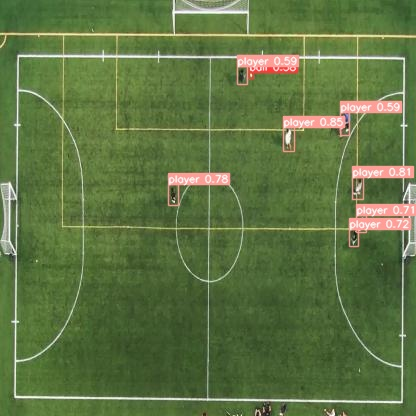

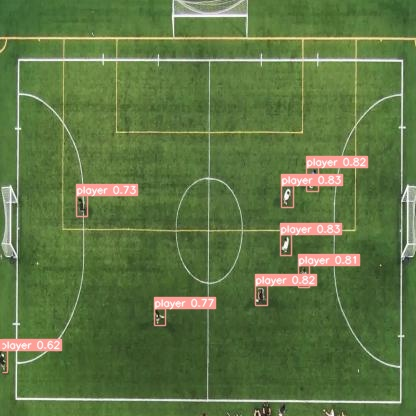

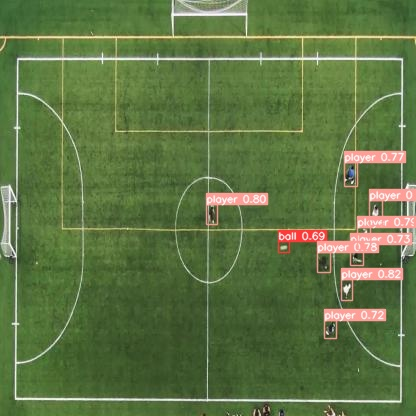

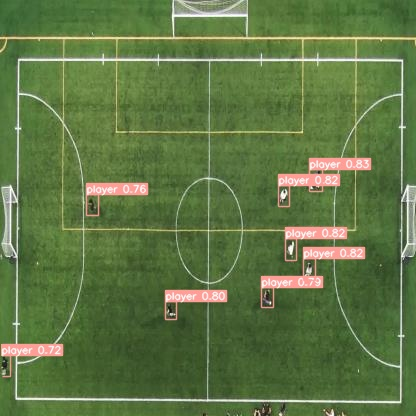

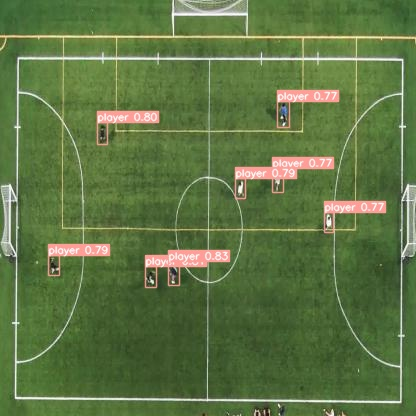

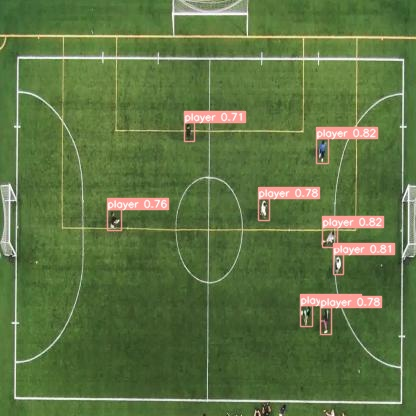

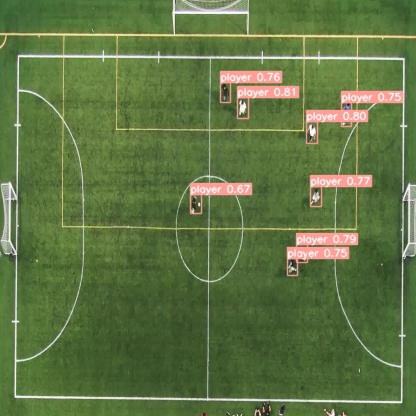

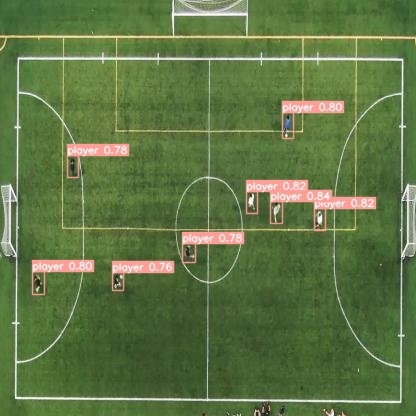

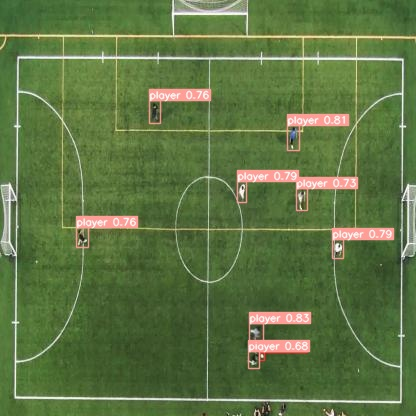

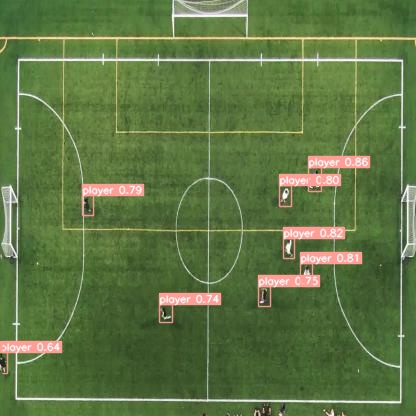

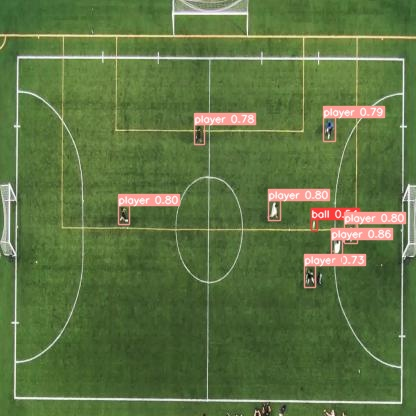

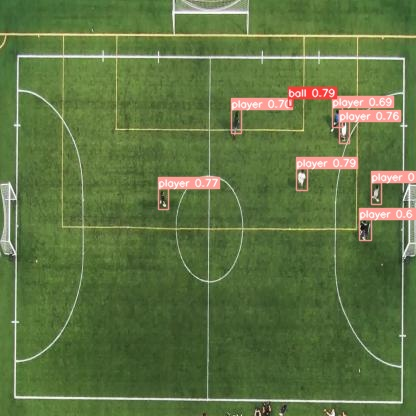

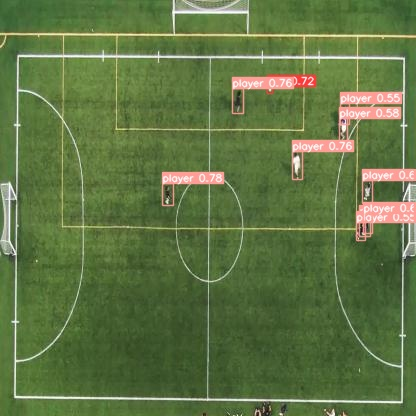

In [ ]:
import glob
from IPython.display import Image, display

for image in glob.glob('/content/yolov5/runs/detect/exp/*.jpg')[:63]:
    display(Image(filename=image))
    print("\n")

# Test images from internet

In [ ]:
# final weights will be stored by default at /content/yolov5/runs/train/exp2/weights/best.pt

#Here we will use the detect.py script to evaluate the model with images that 
#do not belong to the original dataset. 
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 416 --conf 0.5 --source ./external_test/real/images

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=./external_test/real/images, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=1, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-139-g8f35436 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 232 layers, 7249215 parameters, 0 gradients
image 1/41 /content/yolov5/external_test/real/images/01_jpg.rf.1b227cce26eb2b2174ce925b33bff6c9.jpg: 416x416 6 players, Done. (0.031s)
image 2/41 /content/yolov5/external_test/real/images/01_jpg.rf.4bd840e7433cdc39a59588bde623f494.jpg: 416x416 3 balls, 13 players, Done. (0.031s)
image 3/41 /content/yolov5/external_test/real/images/01_jpg.rf.967d9c90107180c4243b9016467853ca.jpg: 416x41

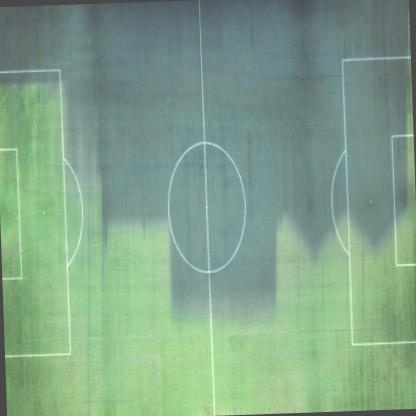

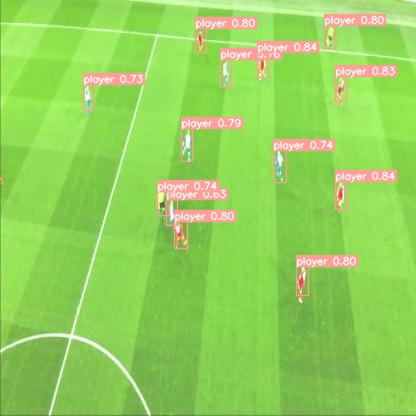

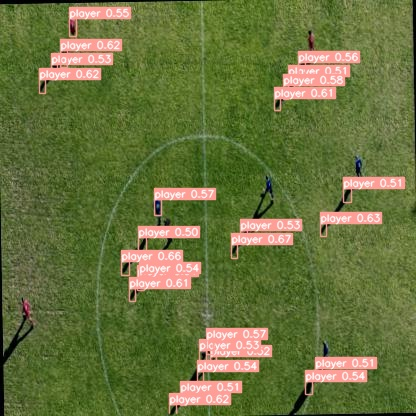

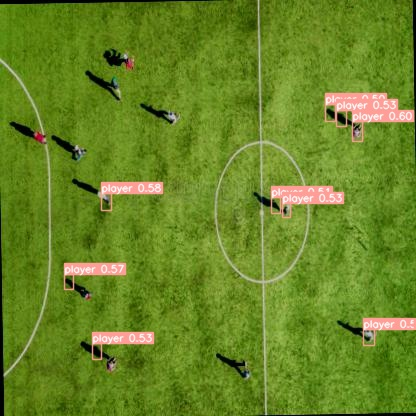

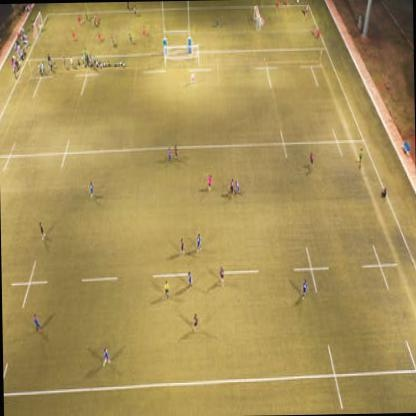

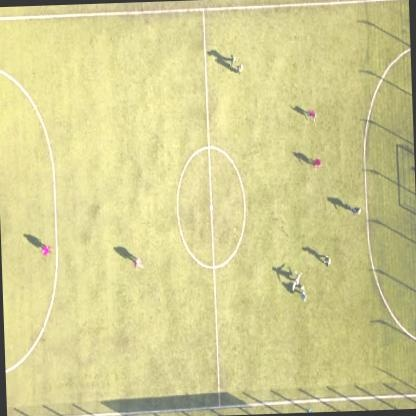

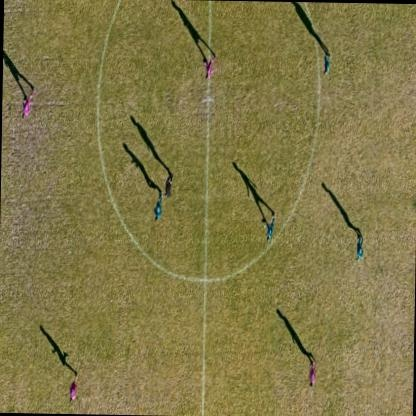

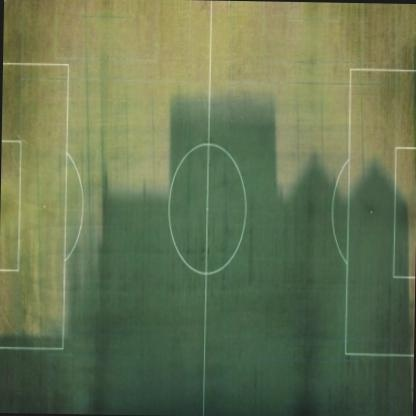

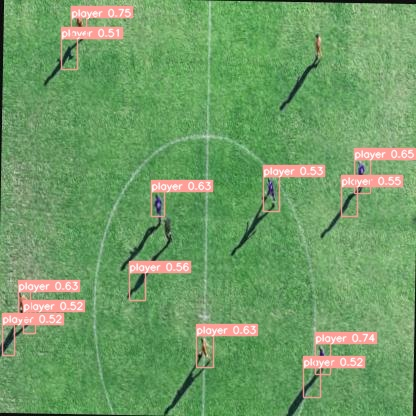

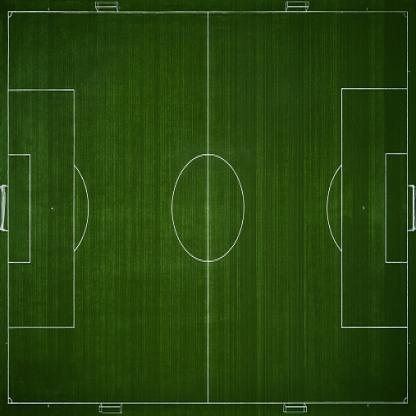

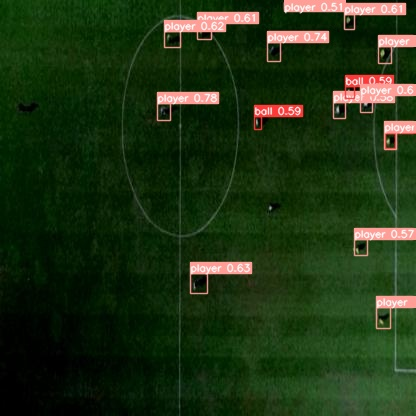

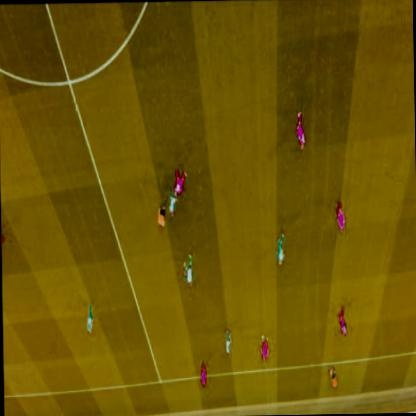

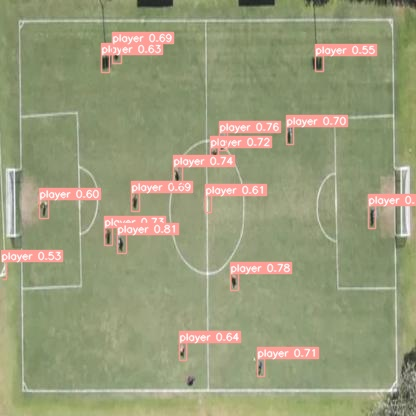

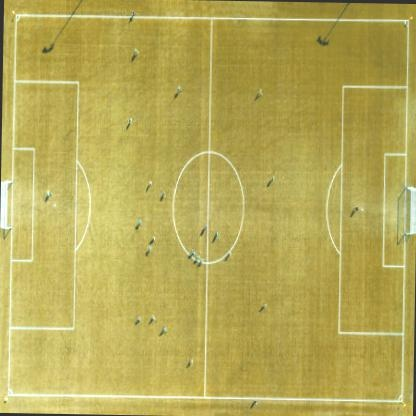

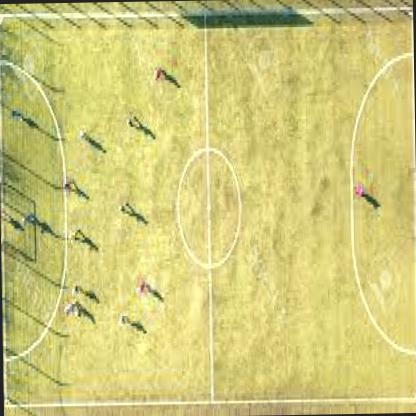

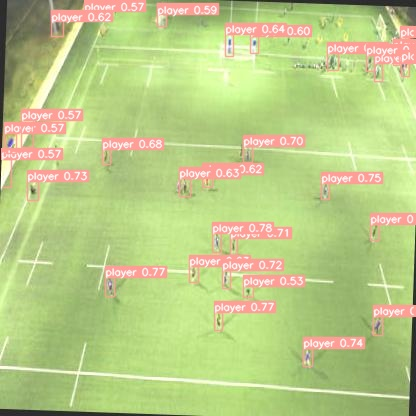

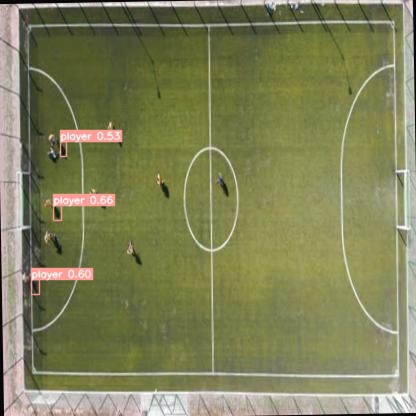

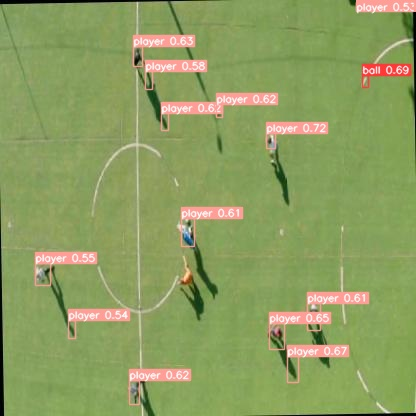

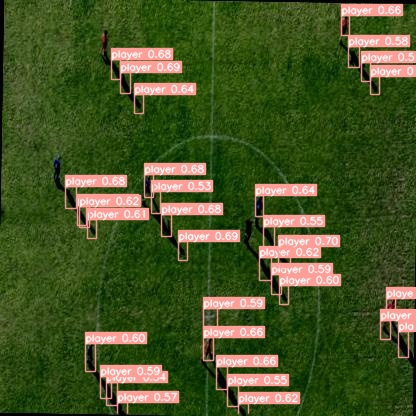

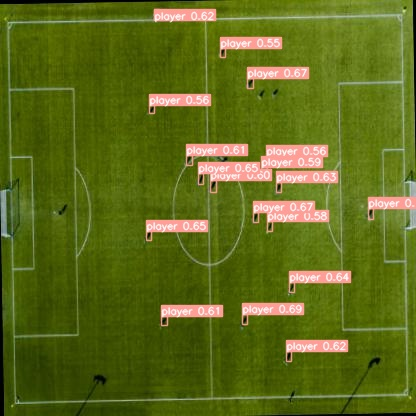

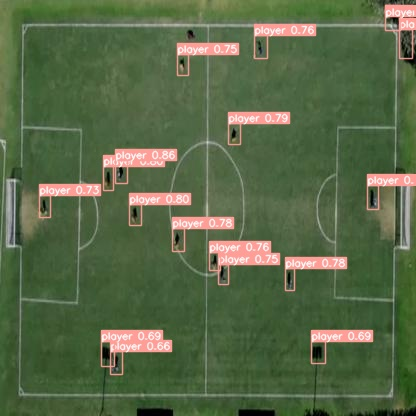

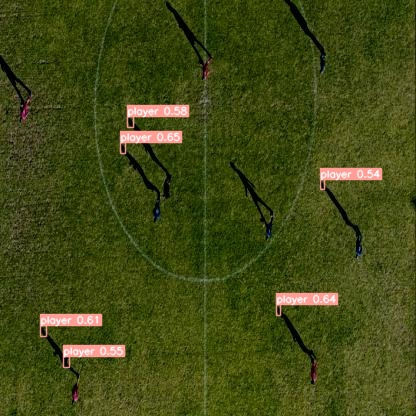

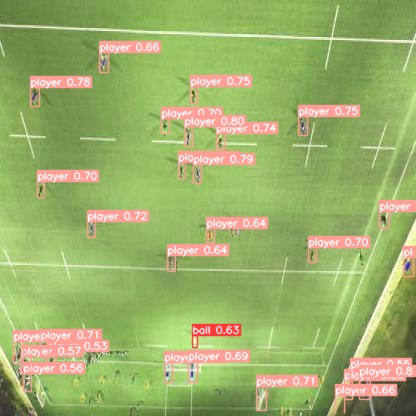

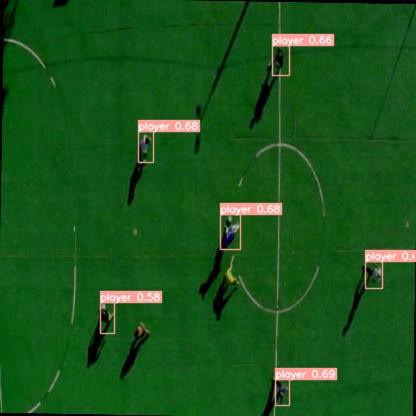

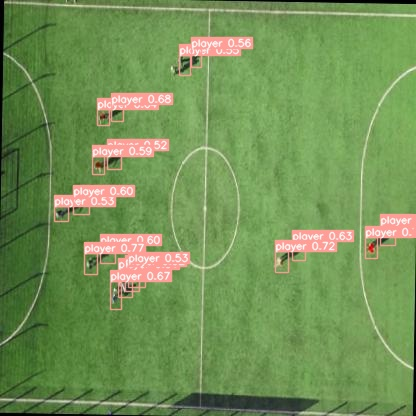

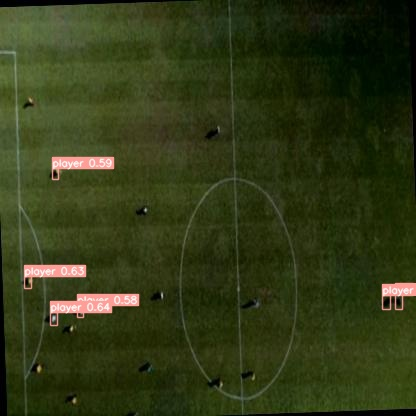

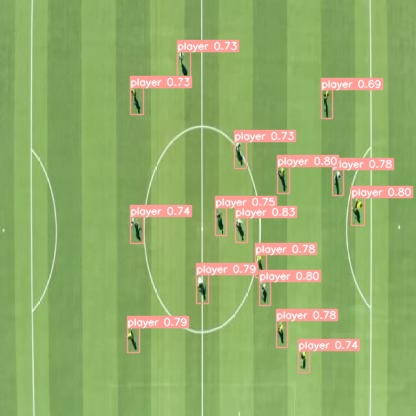

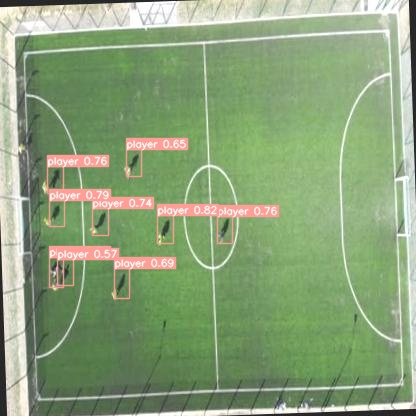

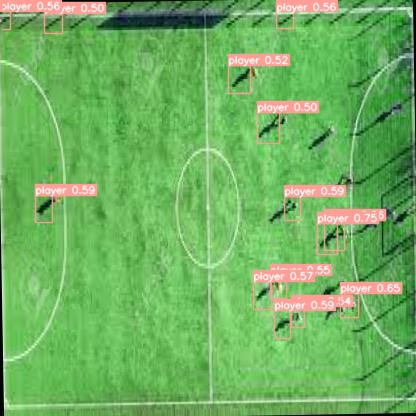

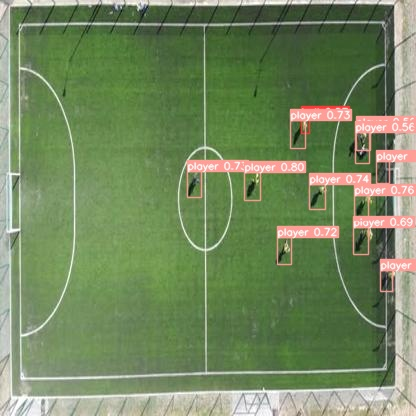

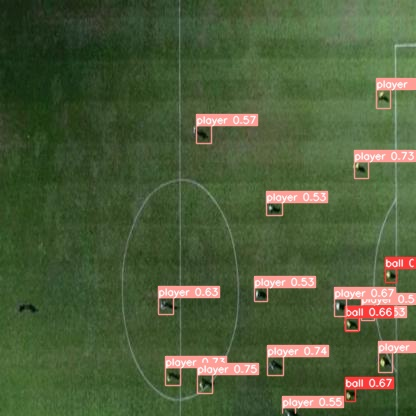

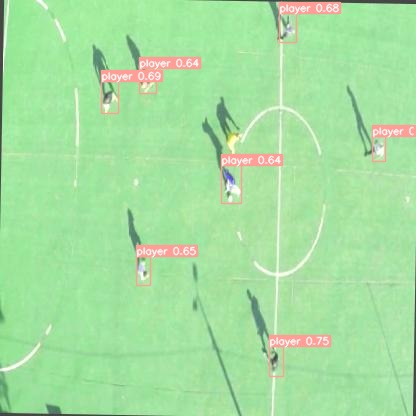

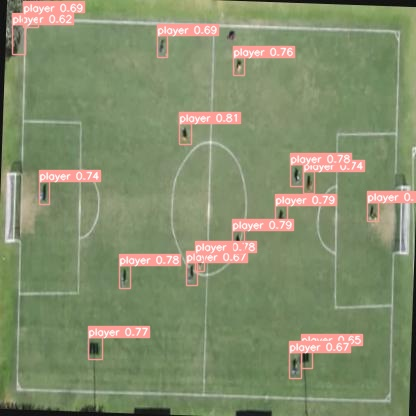

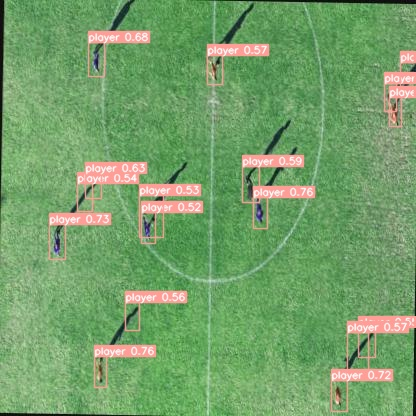

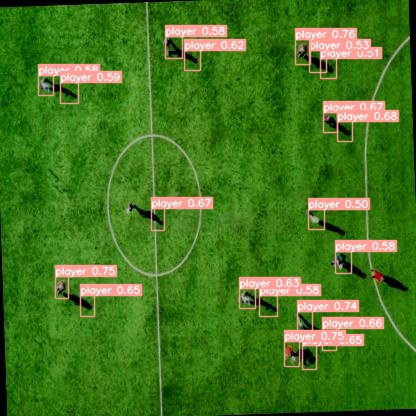

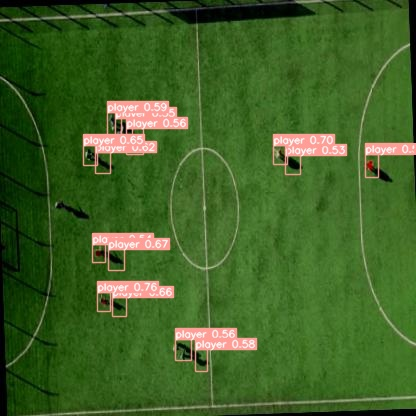

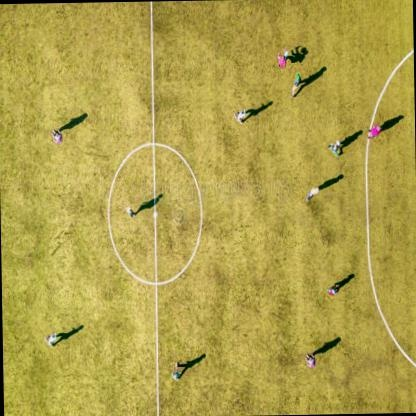

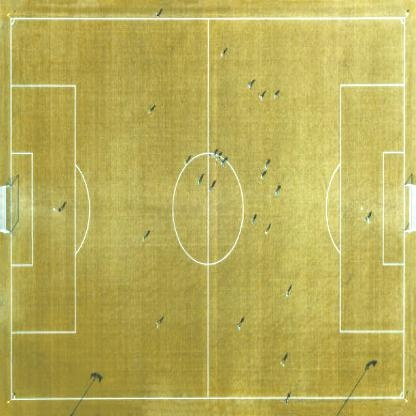

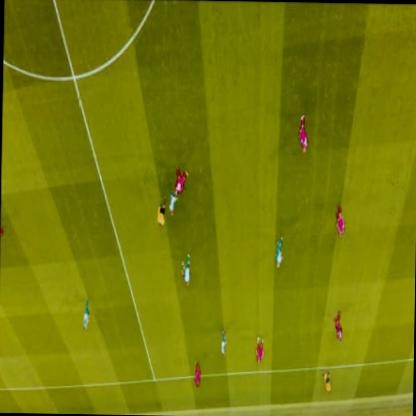

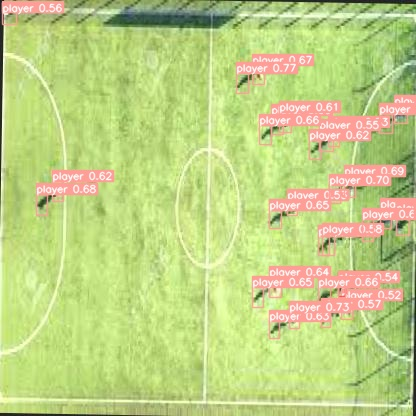

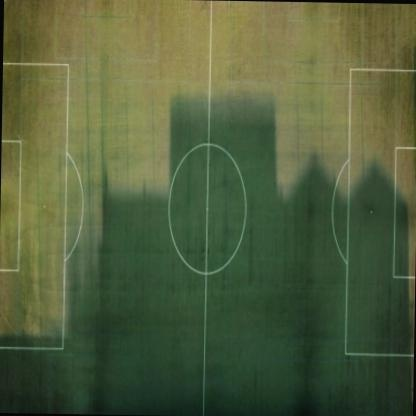

In [ ]:
import glob
from IPython.display import Image, display

for image in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg')[:41]:
    display(Image(filename=image))
    print("\n")

As you can see in the images above, you can see that the results in player recognition are optimal. However, at the moment of recognizing the ball it does not show favorable results as in the previous case. This is due to the number of instances taken for each of the classes. For the class "player" there are approximately 12000 instances, while for the class "ball", the number of instances is only 1500.   

<a href="https://ibb.co/SsqFX4F"><img src="https://i.ibb.co/znKqhTq/instances.jpg" alt="instances" border="0"></a>

## 6. References
[1] YOLO v5 - Train Custom Data https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data

[2] Object Detection Metrics With Worked Example IoU, AP, mAP
https://towardsdatascience.com/on-object-detection-metrics-with-worked-example-216f173ed31e 

[3] IPython documentation https://ipython.readthedocs.io/en/stable/index.html# 

[4] Kaggle dataset "Soccerplayer and Ball localization" https://www.kaggle.com/ramarlina/soccer-player-and-ball-localization

[5] Data augmentation process by Roboflow 